<a href="https://www.kaggle.com/code/lonnieqin/spam-filter-using-word-embedding-lstm?scriptVersionId=115862140" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Spam Filter using Word Embedding & LSTM
## Table of Contents
* [1. Import packages](#1.)
* [2. Analytic Approach](#2.)
* [3. Data Requirements](#3.)
* [4. Data Collection](#4.)
* [5. Data Understanding and Preparation](#5.)
    - [5.1 Parse Emails](#5.1)
    - [5.2 Calculate Class Weight for Training](#5.2)
    - [5.3 Preprocesing Emails](#5.3)
    - [5.4 Statistic info of total length of tokenized topic and content](#5.4)
* [6. Modeling](#6.)
* [7. Evaluation](#7.)
    - [7.1 Loss & Accuracy](#7.1)
    - [7.2 Confusion Matrix](#7.2)
    - [7.3 Classification Report](#7.3)
* [8. Conclusions](#8.)

<a id="1."></a>
## 1. Import packages

In [1]:
import os
import email
import random
import email.policy
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn

<a id="2."></a>
## 2. Analytic Approach
An Email comprises of the following elements:
- Sender Address
- Receiver Address
- Topic
- Content
- Attachments (optional)

In daily life, when we read Emails, we can quickly decide that an Email is a Spam if we find following things:
- Topic or Content contains sex, violence, scam or other toxic content. Sometimes we can look at topic or first few words of content to judge that it's a Spam. 
- Attachments contains virus, toxic images, something like that.
- The Sender is in blacklist.

The question is deciding whether an Email is a Spam or not and Email consists of a sequence of texts. This is a Text Classification Problem. We can build a Neural Network with Word Embedding, Bidirectional LSTM layers to solve NLP classification problem. For simplicity we only use topic and content to decide whether or not an Email is a Spam.

<a id="3."></a>
## 3. Data Requirements

In order to solve this problem, we need to collect a list of Emails labeled as Spam or Normal.

<a id="4."></a>
## 4. Data Collection
In this project I will use dataset from https://www.kaggle.com/veleon/ham-and-spam-dataset.
Now data is already downloaded in Kaggle Platfrom. 

In [2]:
base_directory = "/kaggle/input/ham-and-spam-dataset/hamnspam/"
spam_email_names = os.listdir(base_directory + "spam")
normal_email_names = os.listdir(base_directory + "ham")

<a id="5."></a>
<a id="5.1"></a>

### 5. Data Understanding and Preparation

### 5.1 Parse Emails

We will use Python Email Library to Parse these emails. We can also see number of Normal Emails is 5 times of Spam Emails.

In [3]:
def load_email(is_spam, filename):
    directory = base_directory + ("spam" if is_spam else "ham")
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [4]:
spam_emails = [load_email(True, filename) for filename in spam_email_names]
normal_emails = [load_email(False, filename) for filename in normal_email_names]
random.shuffle(spam_emails)
random.shuffle(normal_emails)

In [5]:
print("Number of Spam emails: %d, Number of Normal Emails: %d"%(len(spam_emails), len(normal_emails)))

Number of Spam emails: 501, Number of Normal Emails: 2551


In [6]:
def process_email(emails, label, data_dictionary, default_topic=None):
    for mail in emails:
        payload = mail.get_payload()
        if isinstance(payload, list):
            process_email(payload, label, data_dictionary, default_topic=mail["Subject"])
        else:
            if "Content-Type" in mail.keys():
                if "html" in mail["Content-Type"].lower():
                    try: 
                        soup = BeautifulSoup(mail.get_content())
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = soup.body.text
                        data_dictionary["topic"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                elif "plain" in mail["Content-Type"].lower():
                    try: 
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = mail.get_content()
                        data_dictionary["topic"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                else:
                    pass

In [7]:
data_dictionary = {"topic": [], "content": [], "label": []}
process_email(spam_emails, 1, data_dictionary)
process_email(normal_emails, 0, data_dictionary)
df = pd.DataFrame(data_dictionary)
df.dropna(inplace=True)
df = df.sample(frac=1)

In [8]:
df.head(10)

,topic,content,label
2361,Re: The GOv gets tough on Net Users.....er Pir...,Adam L. Beberg wrote:\n > Forwarding me stuff ...,0
875,The Needle and the damage done,>>From the Hoax or Hack Dept:\nDigital Needle ...,0
648,P2P slogans for EFF,URL: http://boingboing.net/#85485619\nDate: No...,0
2346,[zzzzteana] Scissors are a snip for Third World,"The Times\n\n September 06, 2002\n \n Scissors...",0
824,RE: Re[2]: Goodbye Global Warming,> From: bitbitch@magnesium.net [mailto:bitbitc...,0
2019,Blair attacks new culture of cynicism,"URL: http://www.newsisfree.com/click/-0,835876...",0
2192,Re: CVS report,\n\n\n> > > > Just cvs up'ed and nowadays Catc...,0
773,Colophon 1,URL: http://diveintomark.org/archives/2002/10/...,0
1675,"Re: ""Ouch. Ouch. Ouch. Ouch. Ouch....""(was Re:...",R. A. Hettinga wrote:\n> And then there was th...,0
2443,Glennf responds to warchalking FUD,URL: http://boingboing.net/#85528553\nDate: No...,0


<a id="5.2"></a>
### 5.2 Calculate Class Weight for Training
There are 18% of Label are Spam and 82% of Label Noral, which is a Class Imblance problem. We can calcuate class_weight for training to mitigate this problem.

<AxesSubplot:>

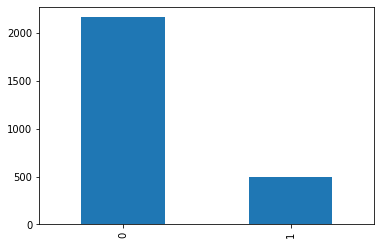

In [9]:
df["label"].value_counts().plot(kind="bar")

In [10]:
class_weight = 1 / df["label"].value_counts()
class_weight = dict(class_weight / class_weight.sum())
class_weight

{0: 0.18623024830699772, 1: 0.8137697516930023}

<a id="5.3"></a>
### 5.3 Preprocesing Emails
Let's start preprocessing texts in following procedures:
1. Change text to lowercased.
2. Remove Stop words

In [11]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
def preprocess_text(content):
    # Change text to lowercased
    content = content.lower()
    # Remove stop words
    for stopword in stopwords:
        content = content.replace(stopword + " ", "")
        content = content.replace(" " + stopword, "")
    return content

In [12]:
num_words = 8196
max_content_length = 512
topic_and_contents = []
for (topic, content) in zip(df["topic"], df["content"]):
    topic_and_contents.append(preprocess_text(topic + " " + content))
df["topic_content"] = topic_and_contents
tokenizer = Tokenizer(num_words=num_words - 1, oov_token="<OOV>")
tokenizer.fit_on_texts(topic_and_contents)

In [13]:
df.head()

,topic,content,label,topic_content
2361,Re: The GOv gets tough on Net Users.....er Pir...,Adam L. Beberg wrote:\n > Forwarding me stuff ...,0,re: tgov getsugh net users.....er pirates..dl....
875,The Needle and the damage done,>>From the Hoax or Hack Dept:\nDigital Needle ...,0,tneedlend tdamagene >>thoax hack dept:\ndigita...
648,P2P slogans for EFF,URL: http://boingboing.net/#85485619\nDate: No...,0,p2p slogans eff url: http://boingboing.net/#85...
2346,[zzzzteana] Scissors are a snip for Third World,"The Times\n\n September 06, 2002\n \n Scissors...",0,[zzzzteana] scissorsre snip third world ttimes...
824,RE: Re[2]: Goodbye Global Warming,> From: bitbitch@magnesium.net [mailto:bitbitc...,0,re: re[2]: goodbye global warming >: bitbitch@...


In [14]:
tokenized_topic_and_contents = tokenizer.texts_to_sequences(topic_and_contents)

<a id="5.4"></a>
### 5.4 Statistic info of total length of tokenized topic and content
We will use Word Embedding techniques, input length is very important, that's why we need to learn about statistic info of total length of tokenized topic and content. As we can see, max length of the Emails is 6758 and average length of Emails is about 160, most of the Email's length is less than 500. 

In [15]:
tokenized_topic_and_content_lengths = pd.DataFrame([len(item) for item in tokenized_topic_and_contents])

In [16]:
tokenized_topic_and_content_lengths.describe()

,0
count,2658.000000
mean,144.219338
std,283.987366
min,2.000000
25%,50.000000
50%,89.000000
75%,147.000000
max,6758.000000


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

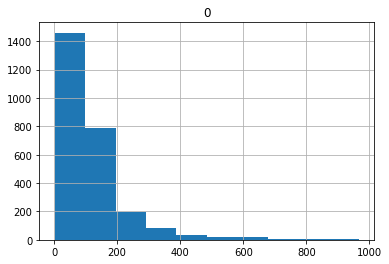

In [17]:
tokenized_topic_and_content_lengths[tokenized_topic_and_content_lengths < 1024].hist()

In [18]:
padding_tokenized_topic_and_contents = pad_sequences(
    tokenized_topic_and_contents, 
    padding='post', 
    truncating='post', 
    maxlen=max_content_length
)

In [19]:
X = np.array(padding_tokenized_topic_and_contents)
y = np.array(df["label"])
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2259, 512), (399, 512), (2259,), (399,))

<a id="6."></a>
### 6. Modeling

In [20]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 256, input_length=max_content_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 256)          2098176   
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 256)          394240    
_________________________________________________________________
dropout (Dropout)            (None, 512, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3

Train the Model for 10 epochs.

In [21]:
checkpoint_path = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), class_weight=class_weight, epochs=10, callbacks=[checkpoint])
model.load_weights(checkpoint_path)

Epoch 1/10
71/71 [==============================] - 133s 2s/step - loss: 0.1775 - accuracy: 0.7005 - val_loss: 0.1301 - val_accuracy: 0.9499
Epoch 2/10
71/71 [==============================] - 126s 2s/step - loss: 0.0317 - accuracy: 0.9801 - val_loss: 0.0954 - val_accuracy: 0.9724
Epoch 3/10
71/71 [==============================] - 125s 2s/step - loss: 0.0156 - accuracy: 0.9886 - val_loss: 0.0726 - val_accuracy: 0.9799
Epoch 4/10
71/71 [==============================] - 125s 2s/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.0749 - val_accuracy: 0.9799
Epoch 5/10
71/71 [==============================] - 127s 2s/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.1932 - val_accuracy: 0.9724
Epoch 6/10
71/71 [==============================] - 127s 2s/step - loss: 0.0058 - accuracy: 0.9973 - val_loss: 0.1318 - val_accuracy: 0.9724
Epoch 7/10
71/71 [==============================] - 126s 2s/step - loss: 0.0050 - accuracy: 0.9978 - val_loss: 0.1314 - val_accuracy: 0.9774
Epoch 8/10
71

<a id="7."></a>
<a id="7.1"></a>
<h2> 7. Evaluation </h2>
<h3> 7.1 Loss & Accuracy </h3>
Plot Loss & Accuracy over time. As we can see, the Model achieve a good result of 98% within 10 epochs.

Text(0.5, 1.0, 'Loss & Accuracy over time')

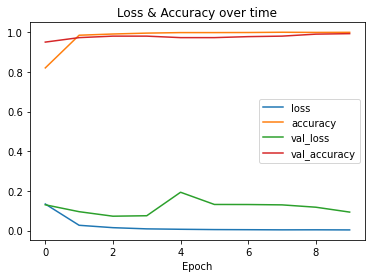

In [22]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(xlabel="Epoch")
plt.title("Loss & Accuracy over time")

In [23]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

<a id="7.2"></a>
<h3> 7.2 Confusion Matrix </h3>

<AxesSubplot:>

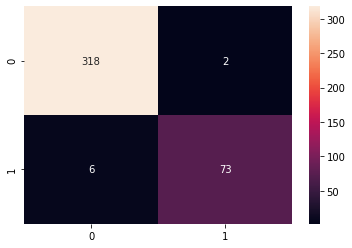

In [24]:
import seaborn as sns
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

<a id="7.3"></a>
<h3> 7.3 Classification Report </h3>

In [25]:
cls_report = sklearn.metrics.classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.97      0.92      0.95        79

    accuracy                           0.98       399
   macro avg       0.98      0.96      0.97       399
weighted avg       0.98      0.98      0.98       399



<a id="8."></a>
<h2> 8. Conclusions </h2>
- This Model can get a very good result. In all Emails that are predicted as Spam, there can hardly be any Normal Emails. Almost all Normal Emails are predicted correctly.
- Data Preparation / Understanding / Preparation comprises of most of the work.
- Modeling and Evaluation comprises a small amount of work while choosing the right Model and appropriate metrics to evaluate the Model is still very important.
- Fine Turning can improve Model's performance.
- Solving data imbalance, such as label imbalance can help the Model achieve a better results.
- With appropriate data preprocessing, the Model can achieve a better performance.
- When we evaluate the Model, we should not only watch out for total accuaracy, but also accuracy accross different labels.